# Assignment 1 | FIT 5202 - Data processing for Big Data


Student: Cristiana Garcia Gewerc

ID: 3008887

## PART B: Analysing CSV Data

### Step 01: Import pyspark and initialize Spark

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# Construct a configuration
conf = SparkConf()
# The `appName` field is a name to be shown on the Sparking cluster UI. 
conf.set("spark.app.name", "Assignment 1B FIT 5202")
# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
conf.set("spark.master", "local[*]")

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(conf=conf)
spark = SparkSession(sparkContext=sc)\
    .builder \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/cristiana.assignment1_coll") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/cristiana.assignment1_coll") \
    .getOrCreate()

### Step 02: Create Dataframe
Write the code to create a dataframe and provide the data source as the CSV file. 

How many records are there in the dataframe? 

<font color=red><b>Answer:</b></font>
<font color=blue><b> There are 727,408 records, as calculated bellow.</b></font>

In [2]:
# create the dataframe
df_crime = spark.read.csv('data/Crime_Statistics_SA_2010_present.csv', header='true')

# display total number of lines
print("The data source has %d lines" %df_crime.count())

The data source has 727408 lines


### Step 03: Write to Database
We will use MongoDB as our data source. Therefore, as a data loading step, you are required to read the CSV file using spark session and insert all the records into MongoDB. Use the overwrite mode when you are inserting the data.

In [3]:
# Write to MongoDB
df_crime.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

### Step 04: Read from Database
Create a Spark DataFrame to hold data from the MongoDB collection specified in the spark.mongodb.input.uri option which your SparkSession option is using. Display the schema of the dataframe. You will use this new dataframe to perform all the steps mentioned below.

In [4]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
# this prints the schema created in Spark using MongoDB
df.printSchema() 

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 05: Calculate the statistics of numeric and string columns
Calculate the statistics of "Offence Count" and "Reported Date". Find the count, mean, standard deviation, minimum and maximum for these attributes. 

Explain with reasoning whether the minimum and maximum reported date is correct.

In [5]:
df["Offence Count","Reported Date"].describe().show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378074|         null|
|    min|                 1|    1/01/2011|
|    max|                 9|    9/12/2018|
+-------+------------------+-------------+



<font color=red><b> Answer:
</b></font>
<font color=blue><b>
The minimum and maximum dates reported are NOT correct because the dates are strings in DD/MM/YYYY format. Given so, the lexical sorting by string value will not be the same as the logical sorting by date.  For instance, 9/11/2001 is going to be considered greater than 1/11/2018. To order the dates properly if they are stored as strings, they need to be in the ISO YYYY/MM/DD standard format.
</b></font>

### Step 06: Change the data type of a column
The Date column is in string format. You need to change it to date format using the user-defined functions (udf).

In [6]:
# first, remove rows with NA values for the date, which could give us problems ahead
df_analysis = df.filter(df['Reported Date'].isNotNull())
# display total number of lines
print("The cleaned data source has %d lines" %df_analysis.count())

The cleaned data source has 727407 lines


In [7]:
# Import function to build a udf and set a date type
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType

# Create the user-defined function to convert the string into a date:

str_to_date =  udf(lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

df_edited = df_analysis.withColumn("Reported Date", str_to_date(df["Reported Date"]))

# Check if the columns "Reported Date" changed correctly its type
df_edited.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 7: Preliminary data analysis
Write the code to answer the following analytical queries.
- How many level2 offences are there? Display the list of level2 offences.

In [8]:
# then, select the distinct level of the desired column
level2 = df_edited.select("Offence Level 2 Description").distinct().collect()
# print number of distinct offences level 2
print("The data source has %d level 2 offences: \n" %len(level2))
#display the list
for row in level2:
    print(row["Offence Level 2 Description"])

The data source has 9 level 2 offences: 

ROBBERY AND RELATED OFFENCES
PROPERTY DAMAGE AND ENVIRONMENTAL
SEXUAL ASSAULT AND RELATED OFFENCES
HOMICIDE AND RELATED OFFENCES
ACTS INTENDED TO CAUSE INJURY
SERIOUS CRIMINAL TRESPASS
OTHER OFFENCES AGAINST THE PERSON
FRAUD DECEPTION AND RELATED OFFENCES
THEFT AND RELATED OFFENCES


<font color=red><b>Answer:</b></font>
<font color=blue><b> The data source has 9 level 2 offences, listed above.</b></font>
- What is the number of offences against the person? 

In [9]:
from pyspark.sql.types import IntegerType
# first, the column "Offence Count" must be numeric so we can sum it
df_integer = df_edited.withColumn("Offence Count", df_edited["Offence Count"].cast("integer"))

# now, we can select only the Offences against person and sum them.
number_against_person = df_integer\
                        .filter(
                            df_edited["Offence Level 1 Description"] == "OFFENCES AGAINST THE PERSON")\
                        .groupBy()\
                        .sum("Offence Count")\
                        .withColumnRenamed("sum(Offence Count)", "Total Offences Against the Person")
number_against_person.show()

+---------------------------------+
|Total Offences Against the Person|
+---------------------------------+
|                           175644|
+---------------------------------+



<font color=red><b>Answer:</b></font>
<font color=blue><b> There are 175,644 offences against the person.</b></font>
- How many serious criminal tresspasses with more than 1 offence count?

In [10]:
df_count = df_integer.filter(df_integer['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS")
total_count = df_count.filter(df_count['Offence Count'] > 1).count()
print("There are %d serious criminal tresspasses with more than 1 offence count." %total_count)

There are 8579 serious criminal tresspasses with more than 1 offence count.


<font color=red><b>Answer:</b></font>
<font color=blue><b> There are 8,579 serious criminal tresspasses with more than 1 offence count.</b></font>
- What percentage of crimes are offences against the property?

In [11]:
# first, calculate the total of crimes as the sum of all offence count values
total_crimes = df_integer.select('Offence Count').groupby().sum().collect()[0]["sum(Offence Count)"]
# then, we filter only crimes against property and sum their occurences
crimes_property = df_integer.filter(df_integer['Offence Level 1 Description'] == 
                                    "OFFENCES AGAINST PROPERTY").select('Offence Count')\
                            .groupby().sum().collect()[0]["sum(Offence Count)"]

In [12]:
# the percentage is the total crimes against the property divided by the total of crimes
print ("The percentage of offences against the property is {0:.1f}%."
            .format(crimes_property/total_crimes*100)) 

The percentage of offences against the property is 79.4%.


<font color=red><b>Answer:</b></font>
<font color=blue><b> The percentage of offences against the property is 79.4%.</b></font>

### Step 08: Exploratory data analysis
Next,write code to analyze the following analytical queries and visualise it using the standard python library - `matplotlib`. Please make sure you are aware of the different factors such as: visual effects, coordinate system, data type and scale and informative interpretation before data visualisation as well as you follow clarity, accuracy and efficiency.

###### - Find the number of crimes per year. Plot the graph and explain your understanding of the graph.

Finding the number of crimes per year:

In [13]:
from pyspark.sql.functions import year, to_timestamp
# prepare the dataframe to plot (recovering the original "df_analysis" to avoid problems ahead)
df_crime = df_analysis.select("Reported Date", "Offence Count")\
                      .withColumn("Year", year(to_timestamp("Reported Date", 'dd/mm/yy')))
# offence count must be integer, otherwise we can't sum it after
df_crime = df_crime.withColumn("Offence Count", df_crime['Offence Count'].cast("integer"))
# finally, the data for our first plot: offences by year
df_plot1 = df_crime.groupby('Year').sum("Offence Count").dropna().sort('Year').collect()

Plotting:

Text(0.5, 1.0, 'Crimes per Year')

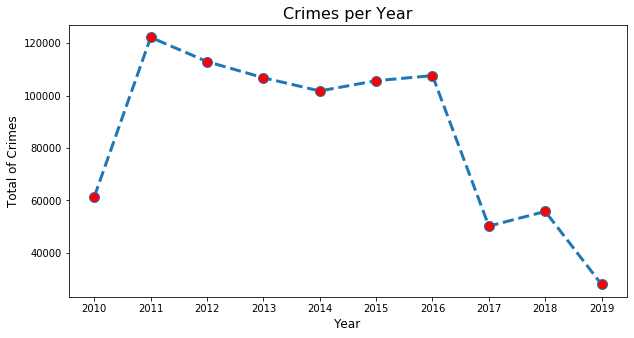

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot1 = [row['Year'] for row in df_plot1]
y_plot1 = [row['sum(Offence Count)'] for row in df_plot1]

plt.figure(figsize=(10,5))
plt.plot(x_plot1, y_plot1 ,marker='o', markerfacecolor='red',markersize=10,linestyle='--', linewidth=3)
plt.xlabel('Year', fontsize=12)
plt.xticks(x_plot1,x_plot1)
plt.ylabel('Total of Crimes', fontsize=12)
plt.title('Crimes per Year', fontsize=16)

<font color=red><b>Answer:</b></font>
<font color=blue><b>
The number of crimes per year have skyrocketed in 2011, with about 2 times the amount of crimes of 2010. It is year with the highest total amount of crimes in our data. After that, it slowly decreased until 2014, presented a small increase in 2015-2016 and then plummeted to half of the occurences of 2016 in 2017, reaching a level bellow the 2010's one. In 2018 the total crimes presented a slight increase comparing to the previous year, but still was in a low level considering the 2010-2019 time period. In 2019, the levels dropped again, to the smaller numbers seem in the graph.
</b></font>
###### - Find the number of crimes per month. Plot the graph and explain your understanding of the graph.

Finding the number of crimes per month and adjusting column data types:

In [15]:
from pyspark.sql.functions import month
# making transformations
df_month = df_analysis.select("Reported Date", "Offence Count").withColumn('Month', month(to_timestamp('Reported Date', 'd/MM/yyyy')))
df_month = df_month.withColumn('Offence Count', df_month['Offence Count'].cast('integer')).withColumn('Month', df_month['Month'].cast('string'))
df_month = df_month.groupby('Month').sum("Offence Count").withColumn('Month', df_month['Month'].cast('integer'))
df_plot2 = df_month.sort('Month').collect()

Plotting:

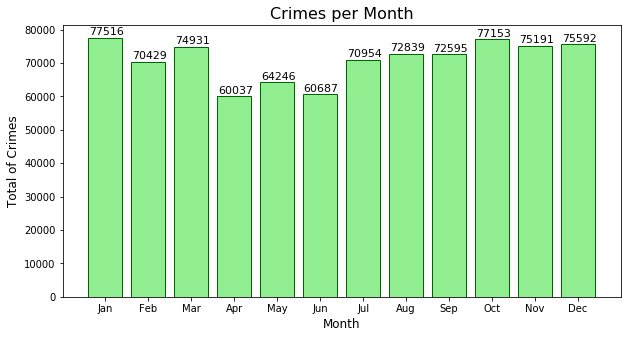

In [16]:
x_plot2 = [row['Month'] for row in df_plot2]
y_plot2 = [row['sum(Offence Count)'] for row in df_plot2]
# list of months for the tick labels:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
#plot
plt.figure(figsize=(10,5))
bars = plt.bar(x_plot2, y_plot2, tick_label= months, edgecolor='darkgreen', color = 'lightgreen')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total of Crimes', fontsize=12)
plt.title('Crimes per Month', fontsize=16)
# text on the top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(x = bar.get_x() + 0.02, y = yval + 800, s = yval, size =11)
plt.show()

<font color=red><b>Answer:</b></font>
<font color=blue><b>
The number of crimes does not fluctuate a lot between the months of the year. The lowest values are seem in April (60,037), while the highest values are seem in January (77,516). Between April and June, the figures are smaller than in the rest of the year. For the other months, they fluctuate around 70,000. We must remember that this is an aggregated data from many years, so, it doesn't mean that in all of those year the patterns were the same.
</b></font>
###### - Where do most crimes take place? Find the top 20 suburbs (which would also display post code for e.g. Caulfield-3162)?. Plot the graph and explain your understanding of the graph

Finding the top 20 suburbs:

In [17]:
from pyspark.sql.functions import concat_ws
# first, I sum the offenses by suburb, sortd in descending order and select the top 20
df_suburb = df_integer.groupby(['Postcode - Incident', 'Suburb - Incident'])\
                     .sum('Offence Count').sort('sum(Offence Count)', ascending = False)\
                     .limit(20)
# then, I concatenate the Postcode and suburb names in order to generate the desired output.
df_plot3 = df_suburb.select(df_suburb['sum(Offence Count)'],
                                      concat_ws('-', 'Suburb - Incident', 
                                                'Postcode - Incident').alias('Suburb')).collect()
# analysing the top suburbs:
for row in df_plot3:
    print(row['Suburb'])

ADELAIDE-5000
PORT AUGUSTA-5700
MOUNT GAMBIER-5290
MURRAY BRIDGE-5253
MORPHETT VALE-5162
SALISBURY-5108
PORT LINCOLN-5606
ELIZABETH-5112
NOT DISCLOSED-NOT DISCLOSED
DAVOREN PARK-5113
PARAFIELD GARDENS-5107
OAKLANDS PARK-5046
PARALOWIE-5108
PROSPECT-5082
PORT PIRIE-5540
MODBURY-5092
SMITHFIELD-5114
SALISBURY NORTH-5108
WHYALLA STUART-5608
MAWSON LAKES-5095


We can see the presence of `NOT DISCLOSED` suburbs and postal code pairs in the data. It is resonable to assume that we shouldn't be grouping them together as a single suburb, and it is polluting our analysis. I'll filter them in order to see the "real" top 20 suburbs in the subsequent graph.

In [18]:
# again, sum the offenses by suburb, sorted in descending order, but select the top 21 
# to subsequently delete the NOT DISCLOSED and have the top 20.
df_suburb = df_integer.groupby(['Postcode - Incident', 'Suburb - Incident'])\
                     .sum('Offence Count').sort('sum(Offence Count)', ascending = False)\
                     .limit(21)
# then, I concatenate the Postcode and suburb names.
df_plot3 = df_suburb.select(df_suburb['sum(Offence Count)'],
                                      concat_ws('-', 'Suburb - Incident', 
                                                'Postcode - Incident').alias('Suburb'))
# filter NOT DISCLOSEDs in order to generate the desired output
df_plot3 = df_plot3.filter(df_plot3.Suburb.isin('NOT DISCLOSED-NOT DISCLOSED') == False).collect()
# analysing the top suburbs:
for row in df_plot3:
    print(row['Suburb'])

ADELAIDE-5000
PORT AUGUSTA-5700
MOUNT GAMBIER-5290
MURRAY BRIDGE-5253
MORPHETT VALE-5162
SALISBURY-5108
PORT LINCOLN-5606
ELIZABETH-5112
DAVOREN PARK-5113
PARAFIELD GARDENS-5107
OAKLANDS PARK-5046
PARALOWIE-5108
PROSPECT-5082
PORT PIRIE-5540
MODBURY-5092
SMITHFIELD-5114
SALISBURY NORTH-5108
WHYALLA STUART-5608
MAWSON LAKES-5095
WHYALLA NORRIE-5608


Plotting horizontal bar chart:

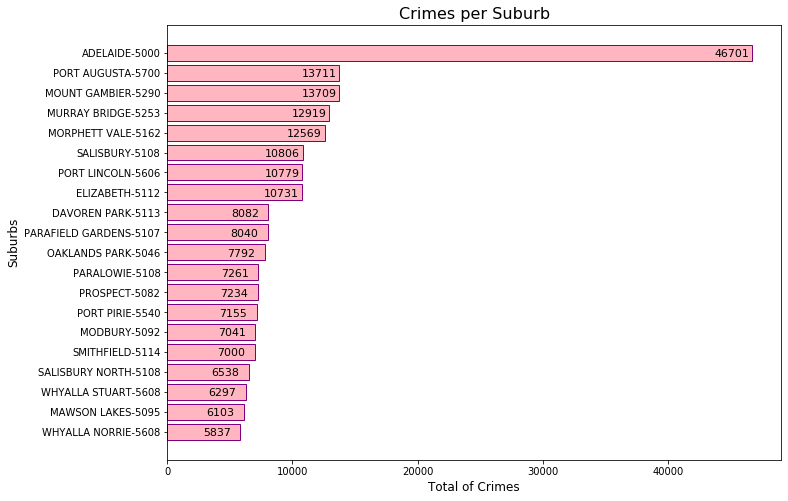

In [19]:
x_plot3 = [row['sum(Offence Count)'] for row in df_plot3]
y_plot3 = [row['Suburb'] for row in df_plot3]
# plot
plt.figure(figsize=(11,8))
bars = plt.barh(y_plot3, x_plot3, edgecolor='purple', color = 'lightpink')
plt.gca().invert_yaxis()
plt.xlabel('Total of Crimes', fontsize=12)
plt.ylabel('Suburbs', fontsize=12)
plt.title('Crimes per Suburb', fontsize=16)
# text on the top of each bar
for i, v in enumerate(x_plot3):
    plt.text(v -3000, i +0.2, str(v), size = 11, color = "black")

plt.show()

<font color=red><b>Answer:</b></font>
<font color=blue><b>
The chart above calls attention for the fact that Adelaide-5000 is by far the suburb with more crimes. It presents a number almost 3 times higher than the second suburb in the ranking of where the most crimes takes place. 
</b></font>

######  - Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

Finding the number of serious criminal trespasses by day and month:

In [20]:
from datetime import datetime
from pyspark.sql.functions import col
# user defined function to get the week day of a given date
day_of_week =  udf(lambda x: datetime.strptime(x, '%d/%m/%Y').strftime('%w'))
# dataframe for the plot: filter crimes of interest, create the weekday column, select only useful columns, 
# create month column, type casting.
df_serious = df_analysis.filter(
    df_analysis['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS').\
    withColumn('Weekday', day_of_week(col('Reported Date'))).\
    select("Reported Date", "Offence Count",'Weekday').\
    withColumn('Month', month(to_timestamp('Reported Date', 'd/MM/yyyy'))).\
    withColumn('Offence Count', df_analysis['Offence Count'].cast('integer'))
#total serious crim trespasses for each weekday-month pair
df_plot4 = df_serious.withColumn('Month', df_serious['Month'].cast('string')).\
    groupby(['Month','Weekday']).sum('Offence Count')
# ordering by month and weekday
df_plot4 = df_plot4.withColumn('Month', df_plot4['Month'].cast('integer')).sort('Month','Weekday').collect()

Preparing the data for plotting:

In [21]:
# dictionaries to tranlate the  months to english
dict_month = dict(zip(list(range(1,13)),months))
# lists of data per weekday, ordered by month
Sunday = [row['sum(Offence Count)'] for row in df_plot4 if row['Weekday'] == '0']
Monday = [row['sum(Offence Count)'] for row in df_plot4 if row['Weekday'] == '1']
Tuesday = [row['sum(Offence Count)'] for row in df_plot4 if row['Weekday'] == '2']
Wednesday = [row['sum(Offence Count)'] for row in df_plot4 if row['Weekday'] == '3']
Thursday = [row['sum(Offence Count)'] for row in df_plot4 if row['Weekday'] == '4']
Friday = [row['sum(Offence Count)'] for row in df_plot4 if row['Weekday'] == '5']
Saturday = [row['sum(Offence Count)'] for row in df_plot4 if row['Weekday'] == '6']

Stacked Bar  Charts:

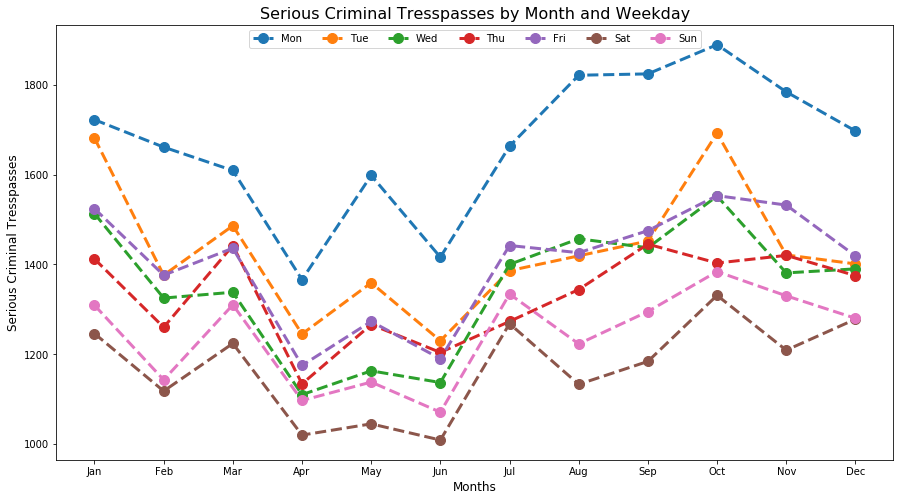

In [22]:
# plot
plt.figure(figsize=(15,8))

ind = list(range(0,12))    # the 12 locations for the months

p1 = plt.plot(ind, Monday, label = 'Mon',marker='o',markersize=10,linestyle='--', linewidth=3)
p2 = plt.plot(ind, Tuesday, label = 'Tue',marker='o',markersize=10,linestyle='--', linewidth=3)
p3 = plt.plot(ind, Wednesday, label = 'Wed',marker='o',markersize=10,linestyle='--', linewidth=3)
p4 = plt.plot(ind, Thursday, label='Thu',marker='o',markersize=10,linestyle='--', linewidth=3)
p5 = plt.plot(ind, Friday, label = 'Fri',marker='o',markersize=10,linestyle='--', linewidth=3)
p6 = plt.plot(ind, Saturday, label = 'Sat',marker='o',markersize=10,linestyle='--', linewidth=3)
p7 = plt.plot(ind, Sunday, label = 'Sun',marker='o',markersize=10,linestyle='--', linewidth=3)

plt.xlabel('Months', fontsize=12)
plt.ylabel('Serious Criminal Tresspasses', fontsize=12)
plt.title('Serious Criminal Tresspasses by Month and Weekday', fontsize=16)
plt.xticks(ind, months)
plt.legend(loc='upper center', ncol=7)

plt.show()

<font color=red><b>Answer:</b></font>
<font color=blue><b>
We can see in the line chart above that serious criminal tresspasses are more frequent on Mondays and less frequent on Saturdays, for all months. October is a month with a high amount of occurences of those crimes for all weekdays, while April and June are low points. The trend along the months for all weekdays is very similar, except for Thursdays in the second half of the year. Overall, the serious criminal tresspasses are less frequent over the weekends.
</b></font>